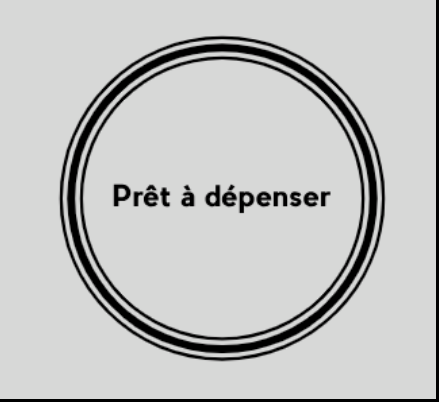

### Vous retrouverez toute ma méthodologie <a href="https://github.com/CLIRD/scoring-app/blob/main/Notes%20m%C3%A9thodologique_OCR.pdf">ici</a>

# <a name = "sommaire"> Sommaire 

- <a href ="#import"> Importation des bibliothèques et des données </a>
- <a href ="#nett"> Prétraitement  </a>
- <a href ="#nett1"> Fusion des dataframes  </a>
- <a href ="#nett2"> Gestion des valeurs manquantes  </a>
  - <a href ="#nett3"> Valeurs numérique  </a>
  - <a href ="#nett4"> Valeurs catégorielles  </a>
- <a href ="#nett5"> Sélection de features </a>
  - <a href ="#nett6"> Pipeline  </a>
  - <a href ="#nett7"> Application de Boruta </a>


# <a name = "import"> Importation des bibliothèques et des données</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
!pip install Boruta &> /dev/null 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gc
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder

from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display='diagram')
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from boruta import BorutaPy
from sklearn.ensemble import ExtraTreesClassifier
import pickle

# <a name = "nett"> Prétraitement</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


def application_train_test():
    df_app_test = pd.read_csv('/content/drive/MyDrive/P7_modèle_de_scoring/data/application_test.csv')
    df_app_train = pd.read_csv('/content/drive/MyDrive/P7_modèle_de_scoring/data/application_train.csv')

    df_train_test = pd.concat([df_app_train, df_app_test], axis = 0)
    df_train_test = df_train_test.query('CODE_GENDER != "XNA"').copy()
    df_train_test['CNT_CHILDREN_CAT'] = pd.cut(df_train_test.CNT_CHILDREN, [0, 2, 4, 21 ],labels=['0-1', '2-3', '>=4'], right=False)
    #df_train_test = df_train_test.query('NAME_FAMILY_STATUS != "Unknown"')
    df_train_test['CNT_FAM_MEMBERS_CAT'] = pd.cut(df_train_test.CNT_FAM_MEMBERS, [0, 2, 4, 6, 22 ],labels=['0-1', '2-3', '4-5', '>=6'], right=False)

    df_train_test.replace(365243, np.nan, inplace = True)

    df_train_test['DAYS_EMPLOYED_PERC'] = df_train_test['DAYS_EMPLOYED'] / df_train_test['DAYS_BIRTH']
    # taux d'endettement
    df_train_test['INCOME_CREDIT_PERC'] = df_train_test['AMT_INCOME_TOTAL'] / df_train_test['AMT_CREDIT']
    df_train_test['ANNUITY_PERC'] = df_train_test['AMT_ANNUITY'] / df_train_test['AMT_INCOME_TOTAL']
    df_train_test['PAYMENT_RATE'] = df_train_test['AMT_ANNUITY'] / df_train_test['AMT_CREDIT']

    df_train_test['CREDIT_TO_GOODS_RATIO'] = df_train_test['AMT_CREDIT'] / df_train_test['AMT_GOODS_PRICE']
    df_train_test['NEW_INC_PER_CHLD'] = df_train_test['AMT_INCOME_TOTAL'] / (1 + df_train_test['CNT_CHILDREN'])
    df_train_test['SOURCES_PROD'] = df_train_test['EXT_SOURCE_1'] * df_train_test['EXT_SOURCE_2'] * df_train_test['EXT_SOURCE_3']
    df_train_test['EXT_SOURCES_MEAN'] = df_train_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df_train_test['EXT_SCORES_STD'] = df_train_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)

    df_train_test['YEARS_EMPLOYED'] = round(df_train_test['DAYS_EMPLOYED'] / 365)
    df_train_test['YEARS_BIRTH'] = round(df_train_test['DAYS_BIRTH'] / 365)
    df_train_test['YEARS_REGISTRATION'] = round(df_train_test['DAYS_REGISTRATION'] / 365)
    df_train_test['YEARS_ID_PUBLISH'] = round(df_train_test['DAYS_ID_PUBLISH'] / 365)

    df_train_test['CAR_TO_BIRTH_RATIO'] = df_train_test['OWN_CAR_AGE'] / df_train_test['DAYS_BIRTH']
    df_train_test['NEW_CAR_TO_EMPLOY_RATIO'] = df_train_test['OWN_CAR_AGE'] / df_train_test['DAYS_EMPLOYED']
    df_train_test['PHONE_TO_BIRTH_RATIO'] = df_train_test['DAYS_LAST_PHONE_CHANGE'] / df_train_test['DAYS_BIRTH']
    df_train_test['PHONE_TO_BIRTH_RATIO_EMPLOYER'] = df_train_test['DAYS_LAST_PHONE_CHANGE'] / df_train_test['DAYS_EMPLOYED']
    del df_app_test
    gc.collect()
    return df_train_test


def bureau_and_balance(nan_as_category = True):
    df_bureau = pd.read_csv('/content/drive/MyDrive/P7_modèle_de_scoring/data/bureau.csv')
    df_bureau_balance = pd.read_csv('/content/drive/MyDrive/P7_modèle_de_scoring/data/bureau_balance.csv')
    bb, bb_cat = one_hot_encoder(df_bureau_balance, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(df_bureau, nan_as_category)

    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
  
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

def previous_applications(nan_as_category = True):
    df_prev_app = pd.read_csv('/content/drive/MyDrive/P7_modèle_de_scoring/data/previous_application.csv')
    prev, cat_cols = one_hot_encoder(df_prev_app, nan_as_category= True)

    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }

    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

def pos_cash(nan_as_category = True):
    pos = pd.read_csv('/content/drive/MyDrive/P7_modèle_de_scoring/data/POS_CASH_balance.csv')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

def installments_payments(nan_as_category = True):
    ins = pd.read_csv('/content/drive/MyDrive/P7_modèle_de_scoring/data/installments_payments.csv')
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

def credit_card_balance(nan_as_category = True):
    cc = pd.read_csv('/content/drive/MyDrive/P7_modèle_de_scoring/data/credit_card_balance.csv')
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# <a name = "nett1"> Fusion des dataframes</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
app_train_test = application_train_test()
app_bureau_and_balance = bureau_and_balance()
app_previous = previous_applications()
app_pos_cash = pos_cash()
app_installments_payments = installments_payments()
app_credit_card_balance = credit_card_balance()
df = app_train_test.merge(app_bureau_and_balance, how = 'left', on = 'SK_ID_CURR')\
                   .merge(app_previous, how = 'left', on = 'SK_ID_CURR')\
                   .merge(app_pos_cash, how = 'left', on = 'SK_ID_CURR')\
                   .merge(app_installments_payments, how = 'left', on = 'SK_ID_CURR')\
                   .merge(app_credit_card_balance, how = 'left', on = 'SK_ID_CURR')
del app_train_test, app_bureau_and_balance, app_previous, app_pos_cash, app_installments_payments, app_credit_card_balance
gc.collect()

0

In [ ]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002.0,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003.0,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004.0,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006.0,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007.0,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# <a name = "nett2"> Gestion des valeurs manquantes</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
def null_values_data_prod_train(data):
    # Garder seulement les prêts avec un id
    data = data[data.SK_ID_CURR.notnull()].copy()
    # Tag si le client à déjà eu une carte de crédit auparavent
    #data['CREDIT_CARD_Y_N'] = data.CC_CNT_DRAWINGS_POS_CURRENT_MAX.apply(lambda x: 0 if x == np.nan else 1)

    # Suppression des colonnes basée sur les cartes de crédit
    #columns_drop = [c for c in data.columns if 'CC_' in c]
    #data.drop(columns_drop, axis = 1, inplace = True)

    # Ici on gardera les colonnes avec un % de valeurs manquantes inférieure ou égale à 50% on perdra certe un peu d'information mais on introduira pas de bias
    data = data[data.columns[data.isnull().sum() / data.shape[0] <= 0.5]]
    print(f'Original data: {data.shape}')

    data_train = data[data.TARGET.notnull()]
    data_prod = data[data.TARGET.isnull()]

    del data
    gc.collect()
    return data_train, data_prod

In [ ]:
data_train, data_prod = null_values_data_prod_train(df)

Original data: (356250, 454)


In [ ]:
def split_data(data):
    X, y = data.drop('TARGET', axis = 1), data.TARGET.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify = y)
    del X, y
    gc.collect()
    return X_train, X_test, y_train, y_test

In [ ]:
data_train = data_train.sample(frac = 0.2, random_state = 0)
data_train.drop('SK_ID_CURR', axis = 1, inplace = True)
X_train, X_test, y_train, y_test = split_data(data_train)

In [ ]:
data_train.to_csv('/content/drive/MyDrive/P7_modèle_de_scoring/data/data_train.csv', index = False)

### <a name = "nett3"> Valeurs numériques </a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
def data_norm(data):
    # Vérifier les colonnes numérique qui suivent une loi normale on les remplacerera par la moyenne sinon par la médiane
    num_data = data.select_dtypes(include=np.number)
    num_data = num_data.loc[:, 'CNT_CHILDREN':]
    # Test statistique (kolmogorov smirnov) avec:
    # Un seuil de 0.05
    # HO : les données suivent une loi normale
    # H1: les données ne suivent pas une loi normale
    cols_norm_mean = []
    cols_median = []
    for i in num_data.columns:
        testk = stats.kstest(num_data[i], 'norm')
        if testk.pvalue > 0.05:
            cols_norm_mean.append(i)
        else: cols_median.append(i)
    del num_data
    gc.collect()
    return cols_norm_mean, cols_median


In [ ]:
cols_norm_mean, cols_median = data_norm(X_train)
# Aucune colonne ne suis une loi normale donc toutes les valeurs manquantes seront remplacer par la médiane

### <a name = "nett3"> Valeurs catégorielles </a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
obj_data = X_train.select_dtypes(exclude = np.number)

In [ ]:
obj_data.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,HOUSETYPE_MODE,EMERGENCYSTATE_MODE,CNT_CHILDREN_CAT,CNT_FAM_MEMBERS_CAT
191650,Revolving loans,M,Y,N,Unaccompanied,Commercial associate,Secondary / secondary special,Married,Rented apartment,Drivers,TUESDAY,Self-employed,block of flats,No,0-1,2-3
241026,Cash loans,F,N,N,Unaccompanied,Commercial associate,Secondary / secondary special,Married,With parents,Secretaries,THURSDAY,Self-employed,block of flats,No,0-1,2-3
51215,Cash loans,F,Y,Y,Unaccompanied,Pensioner,Academic degree,Married,House / apartment,NaN,SATURDAY,XNA,NaN,NaN,0-1,2-3
141019,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Sales staff,MONDAY,Self-employed,block of flats,No,0-1,2-3
141112,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,Core staff,THURSDAY,Government,NaN,NaN,0-1,2-3


In [ ]:
obj_data.isnull().sum() / obj_data.shape[0]

NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
FLAG_OWN_REALTY               0.000000
NAME_TYPE_SUITE               0.004388
NAME_INCOME_TYPE              0.000000
NAME_EDUCATION_TYPE           0.000000
NAME_FAMILY_STATUS            0.000000
NAME_HOUSING_TYPE             0.000000
OCCUPATION_TYPE               0.315573
WEEKDAY_APPR_PROCESS_START    0.000000
ORGANIZATION_TYPE             0.000000
HOUSETYPE_MODE                0.502168
EMERGENCYSTATE_MODE           0.474288
CNT_CHILDREN_CAT              0.000000
CNT_FAM_MEMBERS_CAT           0.000009
dtype: float64

Dans la colonne "NAME_TYPE_SUITE", étant donné qu'il y a peu de valeurs manquantes, nous remplacerons ces valeurs manquantes par la valeur la plus fréquente dans cette colonne. Pour les autres variables étant données du nombres de valeurs manquantes, on remplacera les valeurs manquantes par une constante "XNA" qui indiquera que la valeur est manquante

Pour les colonnes name_education_type, CNT_CHILDREN_CAT, CNT_CHILDREN on va mettre un ordre dans la colonne afin d'utiliser un ordinal encoder.

In [ ]:
X_train['NAME_EDUCATION_TYPE'] = pd.Categorical(X_train.NAME_EDUCATION_TYPE, categories = ['Lower secondary', 'Secondary / secondary special', 'Incomplete higher', 'Higher education', 'Academic degree'], ordered = True)
X_train['CNT_CHILDREN_CAT'] = pd.Categorical(X_train.CNT_CHILDREN_CAT, categories = ['0-1', '2-3', '>=4'], ordered = True)
X_train['CNT_FAM_MEMBERS_CAT'] = pd.Categorical(X_train.CNT_FAM_MEMBERS_CAT, categories = ['0-1', '2-3', '4-5', '>=6'], ordered = True)

Pour les colonnes code_gender, flag_onw_car, flag_onw_reality on utilisera également un ordinal encoder. Pour les autres colonnes, on utilisera un OneHotEncoder 

# <a name = "nett5"> Sélection de features</a> <a href ="#sommaire"> Retour au sommaire</a>

### <a name = "nett6"> Pipeline</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
      X = X.replace([np.inf, -np.inf], np.nan)
      return X.values

In [ ]:
numerical_col = X_train.select_dtypes(include = np.number).columns
categorical_col = X_train.select_dtypes(exclude = np.number).columns

#const_columns = list(obj_data.columns)
const_columns = [i for i in categorical_col if i not in ['OCCUPATION_TYPE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE']]

columns_na = ['OCCUPATION_TYPE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE']

In [ ]:
onehot_transformer = OneHotEncoder()
ordinal_transformer = OrdinalEncoder()
scaler = RobustScaler()
simpleimputer_frequency = SimpleImputer(strategy = "most_frequent")
simpleimputer_constant = SimpleImputer(strategy = "constant", fill_value = "XNA")
simpleimputer_median = SimpleImputer(strategy = "median")

In [ ]:
pipeline_const = make_pipeline(simpleimputer_constant, ordinal_transformer)
pipeline_most_frequente = make_pipeline(simpleimputer_frequency, ordinal_transformer)
pipeline_mediane_scaler = make_pipeline(NumericalTransformer(),simpleimputer_median, scaler)

In [ ]:
preprocessor_f = ColumnTransformer(
    transformers=[
        ('constant_columns', pipeline_const, columns_na),
        ('most_frequent_columns', pipeline_most_frequente, const_columns),
        ('nums_columns', pipeline_mediane_scaler, numerical_col),
    ])
preprocessor_f

ColumnTransformer(transformers=[('constant_columns',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='XNA',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['OCCUPATION_TYPE', 'HOUSETYPE_MODE',
                                  'EMERGENCYSTATE_MODE']),
                                ('most_frequent_columns',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencode...
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       ...
       'INSTAL_AMT_INSTALMENT_MEAN', 'INSTAL_AMT_INSTALMENT_SUM',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT'],
      dtype='object', length=435))])

### <a name = "nett7"> Application de Boruta</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
# ExtraTreesClassifier qui est moins lourd et plus rapide. Qui est recommander pour la selection de features quand on dispose d'un jeu de données trop grands
clf = ExtraTreesClassifier( n_jobs=-1, max_depth=5, class_weight = 'balanced', random_state = 0)
boruta = BorutaPy(clf, random_state=0, n_estimators='auto', verbose = 2)
# J'applique les transformation sur mes colonnes
X_train_f = preprocessor_f.fit_transform(X_train)

# J'entraine boruta sur mon jeu de données
boruta.fit(X_train_f, y_train)

# Récuperation des colonnes les plus importantes
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

In [ ]:
New_x_train = X_train[cols_selected_boruta]

In [ ]:
New_x_train.head()

In [ ]:
path = '/content/drive/MyDrive/P7_modèle_de_scoring/data'

In [ ]:
New_x_train.to_csv(path+'/X_train.csv', index = False)
np.savetxt(path+'/y_train.csv', y_train, delimiter=",", header = 'TARGET', comments = '')
X_test.to_csv(path + '/X_test.csv', index = False)
np.savetxt(path+'/y_test.csv', y_test, delimiter=",", header = 'TARGET', comments = '')
data_prod.to_csv(path+'/data_prod.csv', index = False)